# Citation

Samaneh Mahdavifar, Amgad Hanafy Salem, Princy Victor, Miguel Garzon, Amir H. Razavi, Natasha Hellberg, Arash Habibi Lashkari, “Lightweight Hybrid Detection of Data Exfiltration using DNS based on Machine Learning”, The 11th IEEE International Conference on Communication and Network Security (ICCNS), Dec. 3-5, 2021, Beijing Jiaotong University, Weihai, China.

In [1]:
import re
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Load heavy stateless DNS data

Load each csv file into a corresponding dataframe*

* Heavy stateless data has 3 benign csv files that will be concatenated into a single dataframe

In [2]:
stateless_heavy_audio = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateless_features-heavy_audio.pcap.csv")
stateless_heavy_audio['Category'] = "Audio"
stateless_heavy_compressed = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateless_features-heavy_compressed.pcap.csv")
stateless_heavy_compressed['Category'] = "Compressed"
stateless_heavy_exe = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateless_features-heavy_exe.pcap.csv")
stateless_heavy_exe['Category'] = "Exe"
stateless_heavy_image = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateless_features-heavy_image.pcap.csv")
stateless_heavy_image['Category'] = "Image"
stateless_heavy_text = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateless_features-heavy_text.pcap.csv")
stateless_heavy_text['Category'] = "Text"
stateless_heavy_video = pd.read_csv("../../../../datasets/CICBELLEXFDNS2021/Heavy/Attacks/stateless_features-heavy_video.pcap.csv")
stateless_heavy_video['Category'] = "Video"

stateless_heavy_benign = '../../../../datasets/CICBELLEXFDNS2021/Heavy/Benign/'

# Use regex to get stateless benign data only
stateless_heavy_benign_list = [f"{stateless_heavy_benign}{f}" for f in listdir(stateless_heavy_benign) if isfile(join(stateless_heavy_benign, f)) and re.search("^stateful", f) == None]

stateless_heavy_benign_df = pd.concat(map(pd.read_csv, stateless_heavy_benign_list), ignore_index=True)
stateless_heavy_benign_df['Category'] = "Benign"
stateless_heavy_benign_df['Class'] = "Benign"

In [3]:
stateless_heavy_malicious = pd.concat(
    [
        stateless_heavy_audio,
        stateless_heavy_compressed,
        stateless_heavy_exe,
        stateless_heavy_image,
        stateless_heavy_text,
        stateless_heavy_video,
    ],
    axis=0,
    ignore_index=True
)

stateless_heavy_malicious['Class'] = 'Malicious'

In [4]:
stateless_heavy_data = pd.concat(
    [
        stateless_heavy_malicious,
        stateless_heavy_benign_df
    ],
    axis=0,
    ignore_index=True
)

stateless_heavy_data = stateless_heavy_data.sample(frac=1).reset_index(drop=True)

In [5]:
stateless_heavy_data

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Category,Class
0,2020-11-23 17:46:36.262335,9,0,0,8,0,2.154135,1,2,5,4.000000,bod,bodis,6,0,Benign,Benign
1,2020-11-24 21:04:41.384559,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,Video,Malicious
2,2020-11-24 23:42:35.267373,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,Exe,Malicious
3,2020-11-24 12:03:20.655379,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,Text,Malicious
4,2020-11-24 13:11:56.514421,17,0,0,16,0,2.678258,1,2,13,8.000000,daily,madanyatdaily,14,0,Benign,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433359,2020-11-24 06:07:04.440969,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,Text,Malicious
433360,2020-11-22 10:58:32.885199,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,Benign,Benign
433361,2020-11-22 16:16:07.289708,25,8,0,10,9,2.556642,6,6,7,3.333333,2,192,12,1,Audio,Malicious
433362,2020-11-23 16:12:00.333613,13,0,0,12,0,2.406304,1,2,6,6.000000,awy,mixawy,7,0,Benign,Benign


# 2. Exploratory Data Analysis (EDA)

In [6]:
stateless_heavy_data.head()

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Category,Class
0,2020-11-23 17:46:36.262335,9,0,0,8,0,2.154135,1,2,5,4.000000,bod,bodis,6,0,Benign,Benign
1,2020-11-24 21:04:41.384559,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,Video,Malicious
2,2020-11-24 23:42:35.267373,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1,Exe,Malicious
3,2020-11-24 12:03:20.655379,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,Text,Malicious
4,2020-11-24 13:11:56.514421,17,0,0,16,0,2.678258,1,2,13,8.000000,daily,madanyatdaily,14,0,Benign,Benign


In [7]:
stateless_heavy_data.columns

Index(['timestamp', 'FQDN_count', 'subdomain_length', 'upper', 'lower',
       'numeric', 'entropy', 'special', 'labels', 'labels_max',
       'labels_average', 'longest_word', 'sld', 'len', 'subdomain', 'Category',
       'Class'],
      dtype='object')

In [8]:
stateless_heavy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433364 entries, 0 to 433363
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         433364 non-null  object 
 1   FQDN_count        433364 non-null  int64  
 2   subdomain_length  433364 non-null  int64  
 3   upper             433364 non-null  int64  
 4   lower             433364 non-null  int64  
 5   numeric           433364 non-null  int64  
 6   entropy           433364 non-null  float64
 7   special           433364 non-null  int64  
 8   labels            433364 non-null  int64  
 9   labels_max        433364 non-null  int64  
 10  labels_average    433364 non-null  float64
 11  longest_word      433354 non-null  object 
 12  sld               433364 non-null  object 
 13  len               433364 non-null  int64  
 14  subdomain         433364 non-null  int64  
 15  Category          433364 non-null  object 
 16  Class             43

Show unique DNS exfiltration categories and their respective counts

In [9]:
stateless_heavy_data['Category'].value_counts()

Category
Benign        181694
Text           71102
Video          38012
Image          36386
Audio          35795
Compressed     35746
Exe            34629
Name: count, dtype: int64

Show unique DNS exfiltration classes and their respective counts

In [10]:
stateless_heavy_data['Class'].value_counts()

Class
Malicious    251670
Benign       181694
Name: count, dtype: int64

Check for NaN values

In [11]:
stateless_heavy_data.isna().any()

timestamp           False
FQDN_count          False
subdomain_length    False
upper               False
lower               False
numeric             False
entropy             False
special             False
labels              False
labels_max          False
labels_average      False
longest_word         True
sld                 False
len                 False
subdomain           False
Category            False
Class               False
dtype: bool

Show NaN value counts for each column

In [12]:
stateless_heavy_data.isna().sum()

timestamp            0
FQDN_count           0
subdomain_length     0
upper                0
lower                0
numeric              0
entropy              0
special              0
labels               0
labels_max           0
labels_average       0
longest_word        10
sld                  0
len                  0
subdomain            0
Category             0
Class                0
dtype: int64

In [13]:
stateless_heavy_data[stateless_heavy_data['longest_word'].isna()]

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Category,Class
67522,2020-11-23 17:43:35.431082,16,3,0,13,0,2.068885,3,3,9,4.666667,NaN,nanu-nana,13,1,Benign,Benign
82857,2020-11-22 12:49:32.358071,9,0,0,8,0,1.820802,1,2,5,4.000000,NaN,nanit,6,0,Benign,Benign
131846,2020-11-24 16:09:36.714883,11,0,0,10,0,2.125000,1,2,7,5.000000,NaN,nullphp,8,0,Benign,Benign
172215,2020-11-22 13:29:00.050485,10,0,0,9,0,2.120590,1,2,6,4.500000,NaN,nullpk,7,0,Benign,Benign
234520,2020-11-23 17:43:35.075802,12,0,0,10,0,1.714247,2,2,9,5.500000,NaN,nanu-nana,10,0,Benign,Benign
352208,2020-11-24 16:09:36.680115,11,0,0,10,0,2.125000,1,2,7,5.000000,NaN,nullphp,8,0,Benign,Benign
359702,2020-11-22 13:29:00.097524,10,0,0,9,0,2.120590,1,2,6,4.500000,NaN,nullpk,7,0,Benign,Benign
387700,2020-11-22 12:49:32.531450,13,3,0,11,0,2.067168,2,3,5,3.666667,NaN,nanit,9,1,Benign,Benign
422533,2020-11-23 17:43:35.357937,16,3,0,13,0,2.068885,3,3,9,4.666667,NaN,nanu-nana,13,1,Benign,Benign
433190,2020-11-23 17:43:35.134209,12,0,0,10,0,1.714247,2,2,9,5.500000,NaN,nanu-nana,10,0,Benign,Benign


In [14]:
stateless_heavy_data = stateless_heavy_data.dropna()

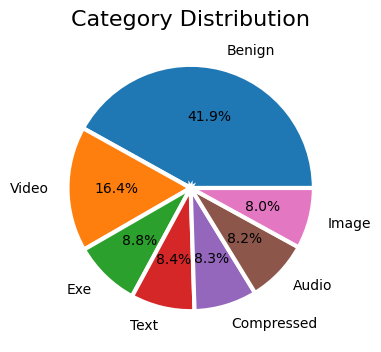

In [15]:
labels = stateless_heavy_data['Category'].unique()
values = stateless_heavy_data['Category'].value_counts()

plt.figure(figsize=(5,4))
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title("Category Distribution", size=16)
plt.show()

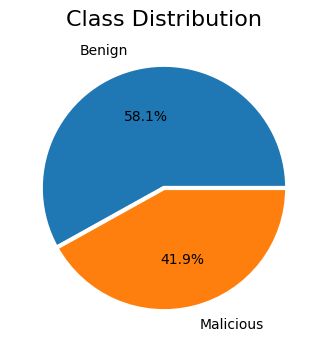

In [16]:
labels = stateless_heavy_data['Class'].unique()
values = stateless_heavy_data['Class'].value_counts()

plt.figure(figsize=(5,4))
plt.pie(values, labels=labels, labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')
plt.title("Class Distribution", size=16)
plt.show()

# 3. Data preparation

1. Separate features from labels
2. Remove timestamps to prevent ML overfitting
3. Use target encoding for categorical columns
4. Encode labels
5. (Optional) Normalize data using [StandardScaler](https://www.geeksforgeeks.org/machine-learning/what-is-standardization-in-machine-learning/)

## 3.1. Separate features from labels

In [17]:
X_stateless_heavy_data = stateless_heavy_data.drop(['Class'], axis=1)
y_stateless_heavy_data = stateless_heavy_data['Class']

## 3.2. Remove timestamps to prevent ML overfiting

In [18]:
X_stateless_heavy_data.drop(['timestamp', 'Category'], axis=1, inplace=True)

In [19]:
X_stateless_heavy_data.head()

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,9,0,0,8,0,2.154135,1,2,5,4.000000,bod,bodis,6,0
1,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
2,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1
3,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
4,17,0,0,16,0,2.678258,1,2,13,8.000000,daily,madanyatdaily,14,0


## 3.3. Target encoding categorical columns

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder

Check unique value count in categorical columns in feature data

In [21]:
categorical_columns = X_stateless_heavy_data.select_dtypes(include='object').columns
for column in categorical_columns:
    print(f"Column: {column}, unique values: {len(stateless_heavy_data[column].unique())}")

Column: longest_word, unique values: 12274
Column: sld, unique values: 32214


Target encode categorical columns

In [22]:
encoder = TargetEncoder(
    categories='auto',
    target_type='binary',  # Categorize between Benign and Malicious
    smooth='auto',
    cv=5,
    random_state=42
)

In [26]:
categorical_columns = X_stateless_heavy_data.select_dtypes(include='object').columns
categorical_columns

In [30]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_stateless_heavy_data, y_stateless_heavy_data, test_size=0.2, random_state=42)

In [32]:
%%time

X_train[categorical_columns] = encoder.fit_transform(X_train[categorical_columns], y_train)

CPU times: user 706 ms, sys: 23.6 ms, total: 729 ms
Wall time: 733 ms


In [33]:
%%time

X_test[categorical_columns] = encoder.transform(X_test[categorical_columns])

CPU times: user 153 ms, sys: 1.89 ms, total: 155 ms
Wall time: 155 ms


## 3.4. Encode labels

In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [38]:
X_train.shape, y_train.shape

((346683, 14), (346683,))

In [39]:
X_test.shape, y_test.shape

((86671, 14), (86671,))

## 3.5. Normalize data

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# 4. Model training

XGBoost will be trained and tested on heavy stateless data

## 4.1. Training

In [42]:
%%time

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

CPU times: user 5.36 s, sys: 97.2 ms, total: 5.45 s
Wall time: 832 ms


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## 4.2. Testing

In [43]:
%%time

y_pred = model.predict(X_test)

CPU times: user 356 ms, sys: 777 μs, total: 357 ms
Wall time: 75.8 ms


In [44]:
from sklearn.metrics import accuracy_score, root_mean_squared_error, mean_squared_error, mean_absolute_error, precision_score, confusion_matrix, multilabel_confusion_matrix, classification_report, f1_score, precision_score, recall_score

In [45]:
results_dict = {}

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
precision = precision_score(y_true=y_test, y_pred=y_pred, average="weighted")
f1 = f1_score(y_true=y_test, y_pred=y_pred, average="weighted")
recall = recall_score(y_true=y_test, y_pred=y_pred, average="weighted")
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) 
rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)

results = [accuracy, precision, f1, recall, mae, mse, rmse]
results_dict["XGB_heavy_stateless"] = results

pd.DataFrame.from_dict(results_dict, orient="index", columns=["Accuracy", "Precision", "F1", "Recall", "MAE", "MSE", "RMSE"])

,Accuracy,Precision,F1,Recall,MAE,MSE,RMSE
XGB_heavy_stateless,0.831432,0.869124,0.821042,0.831432,0.168568,0.168568,0.410571


# 5. Hyperparameter tuning

Hyperparameter tuning using optuna

In [1]:
pass

# 6. Save model

In [46]:
import pickle

In [47]:
dir = '../../../../models/CIC_BELL_EXF_DNS_2021/heavy/stateless/'

with open(f'{dir}XGB_heavy_stateless.pkl', 'wb') as f:
    pickle.dump(model, f)